In [1]:
import itertools
import pandas
import numpy
import glob
import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# settings
protocols = ['fotb', 'totb', 'htlltb', 'htlltbtest']
n_processes = [3, 6, 9, 12]
workload_time = 180
prefixes = [str(a) + "-" + str(b) for a,b in itertools.product(protocols, n_processes)]
colours = ["r", "g", "b", "k"]
markers = ["o", "v", "^", "x"]
linestyles = ['-','--',':','-.']


In [3]:
# check data
print("number of log files: %s" % len(glob.glob('../data/*.log')))
print("expected number of log files: %s" % (len(protocols) * sum(n_processes)))


number of log files: 120
expected number of log files: 120


In [4]:
# preprocessing
results = []

# for each prefix (i.e. benchmark run): fotb-3, ..., htlltbtest-12
for prefix in tqdm.tqdm(prefixes):
    # merge all logs for a prefix into a dataframe df, normalizing the time of each
    # individual history to the minimum time of that history.
    # ignore lines that start with { as these are error messages.
    # first line is the header line.
    # calculate the latency of a broadcast message, as the time difference between 
    # the broadcast and delivery of that message.
    # from the merged logs, we calculate summarizing statistics, 
    # and provide these for each prefix.
    files = glob.glob('../data/' + prefix + '*')
    df = []
    for file in files:
        d = pandas.read_csv(file, sep=' ', comment="{") 
        d["t"] = d["time"] - d["time"].min()
        d["prefix"] = prefix
        d["file"] = file
        d = pandas.merge(d, d[d["operation"] == "deliver"], on=["processid", "messagenumber"], how="left", suffixes=('', '_y'))
        d["latency"] = d["t_y"] - d["t"]
        d["t_old"] = d["t"]
        d["t"] = d["t_y"]
        d = d.filter(["prefix", "file", "operation", "processid", "messagenumber", "t", "latency", "t_old"])
        df.append(d)
    df = pandas.concat(df)
    average_throughput_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "deliver") & (df["t"] < workload_time)]["t"].astype(int)).groupby("t").size()).reset_index().rename({0: "throughput"}, axis=1)
    average_throughput_time_series["throughput"] = average_throughput_time_series["throughput"] / float(df["file"].unique().shape[0])
    average_throughput_time_series = average_throughput_time_series.merge(pandas.DataFrame(range(180), columns=["t"]), on="t", how="right", sort=True).fillna(0.0)
    average_latency_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "broadcast") & (df["t"] < workload_time)])).astype({'t': 'int'}).filter(["t", "latency"]).groupby("t").mean().reset_index()
    average_broadcast_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "broadcast") & (df["t_old"] < workload_time)]["t_old"].astype(int)).groupby("t_old").size()).reset_index().rename({0: "throughput"}, axis=1)
    average_broadcast_time_series = average_broadcast_time_series.merge(pandas.DataFrame(range(180), columns=["t_old"]), on="t_old", how="right", sort=True).fillna(0.0)
    average_broadcast_time_series = average_broadcast_time_series.rename({"t_old": "t"}, axis=1)
    result = {
        "prefix": prefix,
        'throughput_mean': df[ df["operation"] == "deliver"].shape[0] / (workload_time * df["file"].unique().shape[0]),
        'nodes': df["file"].unique().shape[0],
        'average_throughput_time_series': average_throughput_time_series,
        'latency_mean': df[ df["operation"] == "broadcast"]["latency"].mean(),
        'latency_std': df[ df["operation"] == "broadcast"]["latency"].std(),
        "latency_5th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.05),
        "latency_95th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.95),
        'average_latency_time_series': average_latency_time_series,
        'broadcast_mean': df[ df["operation"] == "broadcast" ].shape[0] / float(workload_time),
        'average_broadcast_time_series': average_broadcast_time_series,
    }
    results.append(result)
results = pandas.DataFrame(results)
results


100%|██████████| 16/16 [22:39<00:00, 84.96s/it] 


,prefix,throughput_mean,nodes,average_throughput_time_series,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,average_latency_time_series,broadcast_mean,average_broadcast_time_series
0,fotb-3,739.666667,3,t throughput 0 0 0.000000 1 ...,11.566876,1.591011,9.313366,14.090086,t latency 0 3 3.698510 1 ...,803.683333,t throughput 0 0 1275 1 ...
1,fotb-6,878.647222,6,t throughput 0 0 109.333333 1 ...,44.342577,21.498454,13.192332,81.029024,t latency 0 9 9.511565 1 ...,1543.200000,t throughput 0 0 2484 1 ...
2,fotb-9,897.511111,9,t throughput 0 0 0.000000 1 ...,58.817066,26.857061,16.279734,99.312669,t latency 0 10 10.967446 1 ...,2290.050000,t throughput 0 0 3825 1 ...
3,fotb-12,883.522685,12,t throughput 0 0 0.000000 1 ...,68.524165,33.880346,15.357185,120.292165,t latency 0 9 9.510492 1 ...,2944.500000,t throughput 0 0 5100 1 ...
4,totb-3,445.133333,3,t throughput 0 0 0.000000 1 ...,79.068303,4.840595,69.616644,84.891731,t latency 0 65 65.868625 1 ...,812.116667,t throughput 0 0 1275 1 ...
5,totb-6,523.245370,6,t throughput 0 0 0.000000 1 ...,99.308063,16.095066,62.968389,126.008470,t latency 0 60 60.827943 1 ...,1600.216667,t throughput 0 0 2550 1 ...
6,totb-9,542.282716,9,t throughput 0 0 0.000000 1 ...,107.133270,20.463971,75.291590,137.531613,t latency 0 63 63.555694 1 ...,2311.133333,t throughput 0 0 3825 1 ...
7,totb-12,517.773148,12,t throughput 0 0 0.000000 1 ...,114.049459,22.630082,75.482561,147.677319,t latency 0 71 71.656134 1 ...,3054.500000,t throughput 0 0 5100 1 ...
8,htlltb-3,4529.303704,3,t throughput 0 0 3932.666667 1 ...,0.068104,0.032130,0.027931,0.129734,t latency 0 0 0.067805 1 1...,4534.766667,t throughput 0 0 4422 1 ...
9,htlltb-6,7446.037037,6,t throughput 0 0 6483.166667 1 ...,0.079565,0.041915,0.028518,0.158364,t latency 0 0 0.090242 1 1...,7459.761111,t throughput 0 0 6915 1 ...


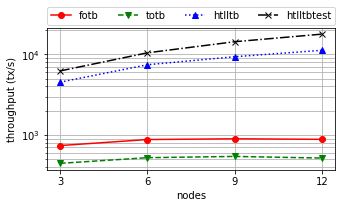

In [5]:
# throughput
plt.figure(figsize=(1.618 * 3, 3))

for protocol, col, marker, ls in zip(protocols, colours, markers, linestyles):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.plot(r["nodes"], r["throughput_mean"], label=protocol, marker=marker, c=col, ls=ls)

plt.xticks([3, 6, 9, 12])
plt.ylabel("throughput (tx/s)")
plt.xlabel("nodes")
plt.title(" ")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()
plt.savefig("../reports/throughput.pdf")


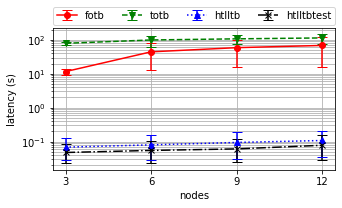

In [6]:
# latency plot with 5th and 95th quantile
plt.figure(figsize=(1.618 * 3, 3))

for protocol, col, marker, ls in zip(protocols, colours, markers, linestyles):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.errorbar(
        r["nodes"], 
        r["latency_mean"], 
        [
            r["latency_mean"] - r["latency_5th_quantile"], 
            r["latency_95th_quantile"] - r["latency_mean"]], 
        c=col,
        label=protocol,
        capsize=5,
        marker=marker,
        ls=ls,
    )

plt.xticks([3, 6, 9, 12])
plt.ylabel("latency (s)")
plt.xlabel("nodes")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()
plt.savefig("../reports/latency.pdf")


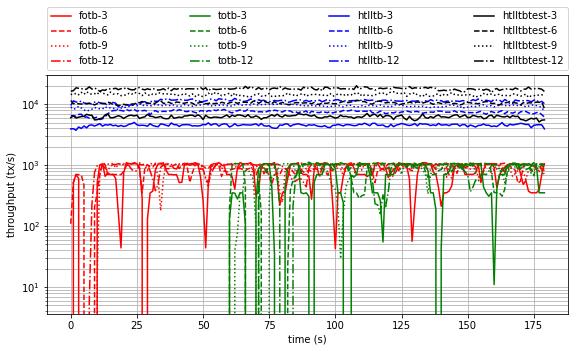

In [7]:
# throughput time series
plt.figure(figsize=(1.618 * 5, 5))

for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=col, linestyle=ls)

plt.ylabel("throughput (tx/s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()


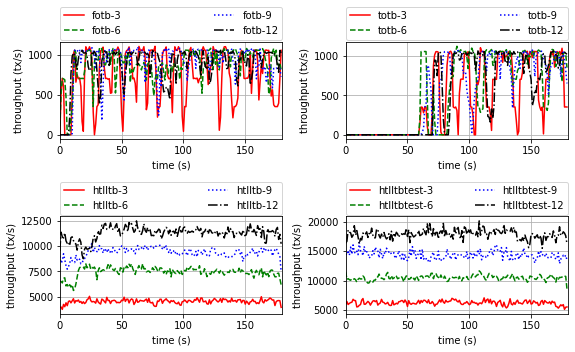

In [8]:
# throughput time series
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, (protocol) in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        axs[i].plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=c, linestyle=ls)

    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/throughputtimeseries.pdf")


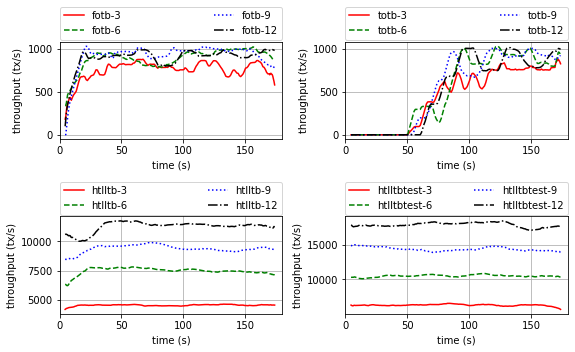

In [9]:
# throughput time series - rolling average over 30-second-window
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        rz = row["average_throughput_time_series"].rolling(window=20, min_periods=0, center=True).mean()
        axs[i].plot(rz["t"], rz["throughput"], label=row["prefix"], c=c, linestyle=ls)
    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/throughputtimeseriessmooth.pdf")


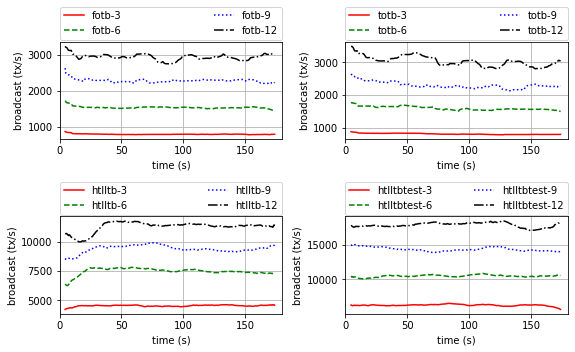

In [10]:
# broadcast time series - rolling average over 20-second-window
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        rz2 = row["average_broadcast_time_series"].rolling(window=20, min_periods=0, center=True).mean()
        axs[i].plot(rz2["t"], rz2["throughput"], label=row["prefix"], c=c, linestyle=ls)    
    axs[i].set_ylabel("broadcast (tx/s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/broadcasttimeseriessmooth.pdf")


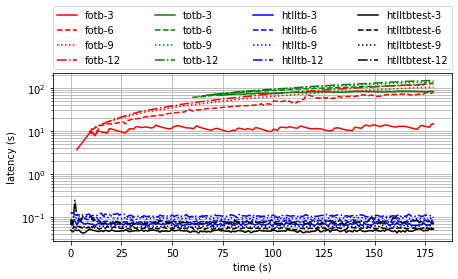

In [11]:
# latency time series
plt.figure(figsize=(1.618 * 4, 4))

for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=col, linestyle=ls)

plt.ylabel("latency (s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()


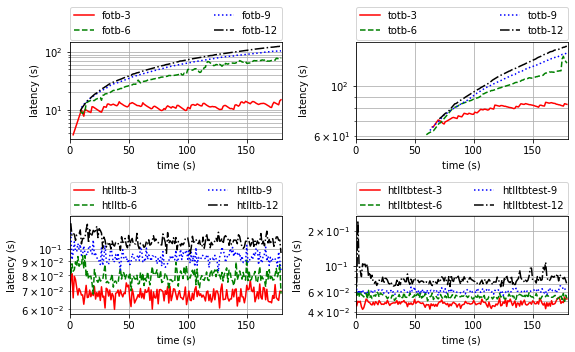

In [12]:
# latency time series
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, protocol in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        axs[i].plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=c, linestyle=ls)

    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_yscale("log")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/latencytimeseries.pdf")


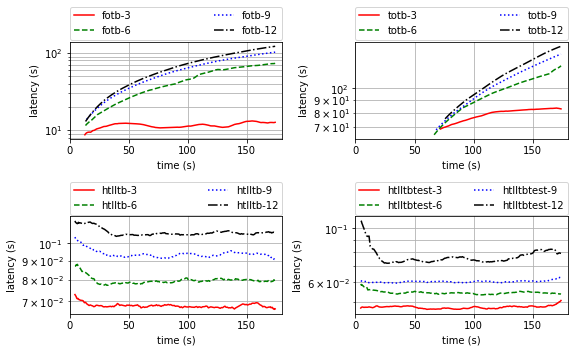

In [13]:
# latency time series - rolling average over 20-second-window
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, protocol in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        rz = row["average_latency_time_series"].rolling(window=20, min_periods=0, center=True).mean()
        axs[i].plot(rz["t"], rz["latency"], label=row["prefix"], c=c, linestyle=ls)
        
    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_yscale("log")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/latencytimeseriessmooth.pdf")


In [14]:
results.filter([
    "prefix",
    "nodes", 
    "throughput_mean",
    "latency_mean",
    "latency_std",
    "latency_5th_quantile",
    "latency_95th_quantile",
    "broadcast_mean",
])


,prefix,nodes,throughput_mean,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,broadcast_mean
0,fotb-3,3,739.666667,11.566876,1.591011,9.313366,14.090086,803.683333
1,fotb-6,6,878.647222,44.342577,21.498454,13.192332,81.029024,1543.200000
2,fotb-9,9,897.511111,58.817066,26.857061,16.279734,99.312669,2290.050000
3,fotb-12,12,883.522685,68.524165,33.880346,15.357185,120.292165,2944.500000
4,totb-3,3,445.133333,79.068303,4.840595,69.616644,84.891731,812.116667
5,totb-6,6,523.245370,99.308063,16.095066,62.968389,126.008470,1600.216667
6,totb-9,9,542.282716,107.133270,20.463971,75.291590,137.531613,2311.133333
7,totb-12,12,517.773148,114.049459,22.630082,75.482561,147.677319,3054.500000
8,htlltb-3,3,4529.303704,0.068104,0.032130,0.027931,0.129734,4534.766667
9,htlltb-6,6,7446.037037,0.079565,0.041915,0.028518,0.158364,7459.761111
